In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
import warnings
import itertools as it
import time
from tqdm.notebook import tqdm

from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm
from fbprophet import Prophet
from pyramid.arima import auto_arima
from statsmodels.tsa.vector_ar.var_model import VAR

from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.

/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https:/

## Training dataset provided by Zindi

In [2]:
covid = pd.read_csv('train.csv')
covid.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20


In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16929 entries, 0 to 16928
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Territory X Date  16929 non-null  object
 1   target            16929 non-null  int64 
 2   cases             16929 non-null  int64 
 3   Territory         16929 non-null  object
 4   Date              16929 non-null  object
dtypes: int64(2), object(3)
memory usage: 661.4+ KB


In [4]:
covid.Date = pd.to_datetime(covid.Date)
covid.Territory = covid.Territory.astype('category')
covid['Territory X Date'] = covid['Territory X Date'].astype('category')

In [5]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16929 entries, 0 to 16928
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Territory X Date  16929 non-null  category      
 1   target            16929 non-null  int64         
 2   cases             16929 non-null  int64         
 3   Territory         16929 non-null  category      
 4   Date              16929 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(2)
memory usage: 1.2 MB


In [6]:
# Check missing values for each variable
covid.apply(lambda x: x.isna().sum()).sum()

0

## Reference (test) provided by Zindi 

In [7]:
ref = pd.read_csv('reference.csv')
ref.head()

,Territory X Date,target
0,Afghanistan X 4/12/20,18
1,Afghanistan X 4/13/20,21
2,Afghanistan X 4/14/20,23
3,Afghanistan X 4/15/20,25
4,Afghanistan X 4/16/20,30


## Population dataset : preprocessing

In [8]:
pop = pd.read_csv('other_data/population.csv', usecols=['name', 'pop2020'])
pop.head()

,name,pop2020
0,China,1439323.776
1,India,1380004.385
2,United States,331002.651
3,Indonesia,273523.615
4,Pakistan,220892.340


In [9]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     232 non-null    object 
 1   pop2020  232 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB


In [10]:
pop.pop2020 = pop.pop2020*1000
pop.pop2020 = pop.pop2020.astype(np.int64)

In [11]:
pop.rename(columns={'name' : 'Territory'}, inplace=True)

In [12]:
pop.Territory.unique()

array(['China', 'India', 'United States', 'Indonesia', 'Pakistan',
       'Brazil', 'Nigeria', 'Bangladesh', 'Russia', 'Mexico', 'Japan',
       'Ethiopia', 'Philippines', 'Egypt', 'Vietnam', 'DR Congo',
       'Germany', 'Turkey', 'Iran', 'Thailand', 'United Kingdom',
       'France', 'Italy', 'South Africa', 'Tanzania', 'Myanmar', 'Kenya',
       'South Korea', 'Colombia', 'Spain', 'Argentina', 'Uganda',
       'Ukraine', 'Algeria', 'Sudan', 'Iraq', 'Afghanistan', 'Poland',
       'Canada', 'Morocco', 'Saudi Arabia', 'Uzbekistan', 'Peru',
       'Malaysia', 'Angola', 'Ghana', 'Mozambique', 'Yemen', 'Nepal',
       'Venezuela', 'Madagascar', 'Cameroon', 'Ivory Coast',
       'North Korea', 'Australia', 'Taiwan', 'Niger', 'Sri Lanka',
       'Burkina Faso', 'Mali', 'Romania', 'Chile', 'Malawi', 'Kazakhstan',
       'Zambia', 'Guatemala', 'Ecuador', 'Netherlands', 'Syria',
       'Cambodia', 'Senegal', 'Chad', 'Somalia', 'Zimbabwe', 'Guinea',
       'Rwanda', 'Benin', 'Tunisia', 'Belgiu

In [13]:
# The countries that interest us
right_countries = covid.Territory.unique()
right_countries = pd.DataFrame(right_countries, columns=['Territory'])
right_countries

,Territory
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola
...,...
204,Venezuela (Bolivarian Republic of)
205,Viet Nam
206,Yemen
207,Zambia


In [14]:
# Delete the countries which are in pop and not in covid
data = pd.merge(right_countries, pop, on='Territory')
# Check the lacking countries : which are in covid and not in data
lack_country = set(covid.Territory.unique()) - set(data.Territory.unique())
lack_country

{'Bahamas (the)',
 'Bolivia (Plurinational State of)',
 'Brunei Darussalam',
 'Cabo Verde',
 'Central African Republic (the)',
 'Comoros (the)',
 'Congo (the)',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea (the)",
 'Democratic Republic of the Congo (the)',
 'Dominican Republic (the)',
 'Eswatini',
 'Gambia (the)',
 'Iran (Islamic Republic of)',
 "Lao People's Democratic Republic (the)",
 'Marshall Islands (the)',
 'Micronesia (Federated States of)',
 'Netherlands (the)',
 'Niger (the)',
 'North Macedonia',
 'Philippines (the)',
 'Republic of Korea (the)',
 'Republic of Moldova (the)',
 'Russian Federation (the)',
 'Saint Barthelemy',
 'St Martin',
 'Sudan (the)',
 'Syrian Arab Republic (the)',
 'United Arab Emirates (the)',
 'United Kingdom of Great Britain and Northern Ireland (the)',
 'United Republic of Tanzania (the)',
 'United States of America (the)',
 'Venezuela (Bolivarian Republic of)',
 'Viet Nam'}

In [15]:
# Standardization of the names of the countries
pop.loc[pop['Territory'] == 'United Arab Emirates', 'Territory'] = 'United Arab Emirates (the)'
pop.loc[pop['Territory'] == 'Philippines', 'Territory'] = 'Philippines (the)'
pop.loc[pop['Territory'] == 'Dominican Republic', 'Territory'] = 'Dominican Republic (the)'
pop.loc[pop['Territory'] == 'Brunei', 'Territory'] = 'Brunei Darussalam'
pop.loc[pop['Territory'] == 'US', 'Territory'] = 'United States of America (the)'
pop.loc[pop['Territory'] == 'Iran', 'Territory'] = 'Iran (Islamic Republic of)'
pop.loc[pop['Territory'] == 'Korea, South'] = "Democratic People's Republic of Korea (the)"
pop.loc[pop['Territory'] == 'Vietnam', 'Territory'] = 'Viet Nam'
pop.loc[pop['Territory'] == 'Russia', 'Territory'] = 'Russian Federation (the)'
pop.loc[pop['Territory'] == 'Moldova', 'Territory'] = 'Republic of Moldova (the)'
pop.loc[pop['Territory'] == 'Bolivia', 'Territory'] = 'Bolivia (Plurinational State of)'
pop.loc[pop['Territory'] == 'United Kingdom', 'Territory'] = 'United Kingdom of Great Britain and Northern Ireland (the)'
pop.loc[pop['Territory'] == 'Congo (Kinshasa)', 'Territory'] = 'Democratic Republic of the Congo (the)' 
pop.loc[pop['Territory'] == "Ivory cost", 'Territory'] = "Côte d'Ivoire"
pop.loc[pop['Territory'] == 'Sudan', 'Territory'] = "South Sudan" #?
pop.loc[pop['Territory'] == 'Venezuela', 'Territory'] = "Venezuela (Bolivarian Republic of)"
pop.loc[pop['Territory'] == 'Central African Republic', 'Territory'] = 'Central African Republic (the)'
pop.loc[pop['Territory'] == 'Congo (Brazzaville)', 'Territory'] = 'Congo (the)'
pop.loc[pop['Territory'] == 'Netherlands', 'Territory'] = 'Netherlands (the)'
pop.loc[pop['Territory'] == 'Tanzania', 'Territory'] = 'United Republic of Tanzania (the)'
pop.loc[pop['Territory'] == 'Gambia', 'Territory'] = 'Gambia (the)'
pop.loc[pop['Territory'] == 'Bahamas', 'Territory'] = 'Bahamas (the)'
pop.loc[pop['Territory'] == 'Niger', 'Territory'] = 'Niger (the)'
pop.loc[pop['Territory'] == 'Syria', 'Territory'] = 'Syrian Arab Republic (the)'
pop.loc[pop['Territory'] == 'Laos', 'Territory'] = "Lao People's Democratic Republic (the)"

In [16]:

pop[pop['Territory'] == 'Viet Nam']

,Territory,pop2020
14,Viet Nam,97338579


In [17]:
# Check if remain lacking countries
data = pd.merge(right_countries, pop, on='Territory')
lack_country = set(covid.Territory.unique()) - set(data.Territory.unique())
lack_country

{'Cabo Verde',
 'Comoros (the)',
 'Congo (the)',
 'Czechia',
 "Côte d'Ivoire",
 "Democratic People's Republic of Korea (the)",
 'Democratic Republic of the Congo (the)',
 'Eswatini',
 'Marshall Islands (the)',
 'Micronesia (Federated States of)',
 'North Macedonia',
 'Republic of Korea (the)',
 'Saint Barthelemy',
 'St Martin',
 'Sudan (the)',
 'United States of America (the)'}

In [18]:
# Add the lacking countries
data = data.append(pd.DataFrame({'Territory' : 'United States of America (the)', 'pop2020' : [328_200_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Congo (the)', 'pop2020' : [69_360_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Comoros (the)', 'pop2020' : [832_322]}))
data = data.append(pd.DataFrame({'Territory' : 'Czechia', 'pop2020' : [10_650_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Côte d\'Ivoire', 'pop2020' : [25_070_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Democratic People\'s Republic of Korea (the)', 'pop2020' : [25_550_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Democratic Republic of the Congo (the)', 'pop2020' : [84_070_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Eswatini', 'pop2020' : [1_136_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Marshall Islands (the)', 'pop2020' : [58_413]}))
data = data.append(pd.DataFrame({'Territory' : 'Micronesia (Federated States of)', 'pop2020' : [112_640]}))
data = data.append(pd.DataFrame({'Territory' : 'North Macedonia', 'pop2020' : [2_077_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Republic of Korea (the)', 'pop2020' : [51_640_000]}))
data = data.append(pd.DataFrame({'Territory' : 'Saint Barthelemy', 'pop2020' : [9_131]}))
data = data.append(pd.DataFrame({'Territory' : 'St Martin', 'pop2020' : [37_264]}))
data = data.append(pd.DataFrame({'Territory' : 'Sudan (the)', 'pop2020' : [41_800_000 ]}))
data = data.append(pd.DataFrame({'Territory' : 'Cabo Verde', 'pop2020' : [543_767]}))

data.iloc[162,1] = data.iloc[163,1]
data.drop_duplicates(inplace=True)

In [19]:
# Check if remain lacking countries
lack_country = set(covid.Territory.unique()) - set(data.Territory.unique())
lack_country

set()

In [20]:
data[data.Territory == 'Nigeria']

,Territory,pop2020
127,Nigeria,206139589


In [21]:
# Check if there are countries duplicated
data.Territory[data.Territory.duplicated()]

Series([], Name: Territory, dtype: object)

In [22]:
data.pop2020.dtype

dtype('O')

In [23]:
data.pop2020 = data.pop2020.astype(np.int64)

In [24]:
data.pop2020.dtype

dtype('int64')

In [25]:
# Check if we have the same countries in covid dataset and in population dataset
set(data.Territory.unique()) == set(covid.Territory.unique())

True

In [26]:
# Merge covid and population dataset
covid = covid.merge(data, on='Territory')
covid.head()

,Territory X Date,target,cases,Territory,Date,pop2020
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22,38928346
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23,38928346
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24,38928346
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25,38928346
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26,38928346


In [27]:
# Add Case Fatality Rate variable 
def CFR(x):
    if x['cases'] != 0:
        return x['target'] / x['cases']
    else:
        return 0
    
covid['CFR'] = covid.loc[:,'target':'cases'].apply(lambda x: CFR(x), axis=1)

In [28]:
# Build a population time series by country based-on the target (death) variable
covid.pop2020 = covid.pop2020 - covid.target

In [29]:
# Add Infection Fatality Rate variable 
def IFR(x):
    return x['target'] / x['pop2020']
    
covid['IFR'] = covid.loc[:,'target':'pop2020'].apply(lambda x: IFR(x), axis=1)

In [30]:
covid.head()

,Territory X Date,target,cases,Territory,Date,pop2020,CFR,IFR
0,Afghanistan X 1/22/20,0,0,Afghanistan,2020-01-22,38928346,0.0,0.0
1,Afghanistan X 1/23/20,0,0,Afghanistan,2020-01-23,38928346,0.0,0.0
2,Afghanistan X 1/24/20,0,0,Afghanistan,2020-01-24,38928346,0.0,0.0
3,Afghanistan X 1/25/20,0,0,Afghanistan,2020-01-25,38928346,0.0,0.0
4,Afghanistan X 1/26/20,0,0,Afghanistan,2020-01-26,38928346,0.0,0.0


In [31]:
# Reordering columns
covid = covid[['Date', 'target', 'cases', 'pop2020', 'CFR', 'IFR', 'Territory']]
covid.head()

,Date,target,cases,pop2020,CFR,IFR,Territory
0,2020-01-22,0,0,38928346,0.0,0.0,Afghanistan
1,2020-01-23,0,0,38928346,0.0,0.0,Afghanistan
2,2020-01-24,0,0,38928346,0.0,0.0,Afghanistan
3,2020-01-25,0,0,38928346,0.0,0.0,Afghanistan
4,2020-01-26,0,0,38928346,0.0,0.0,Afghanistan


## overview of the Cameroon's time series 

In [32]:
cam = covid[covid.Territory == 'Cameroon'][['target', 'Date']].set_index('Date')
cam.head()

,target
Date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0


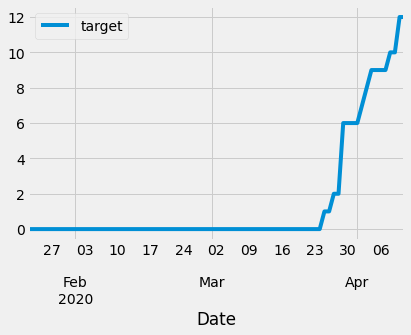

In [33]:
cam.plot()

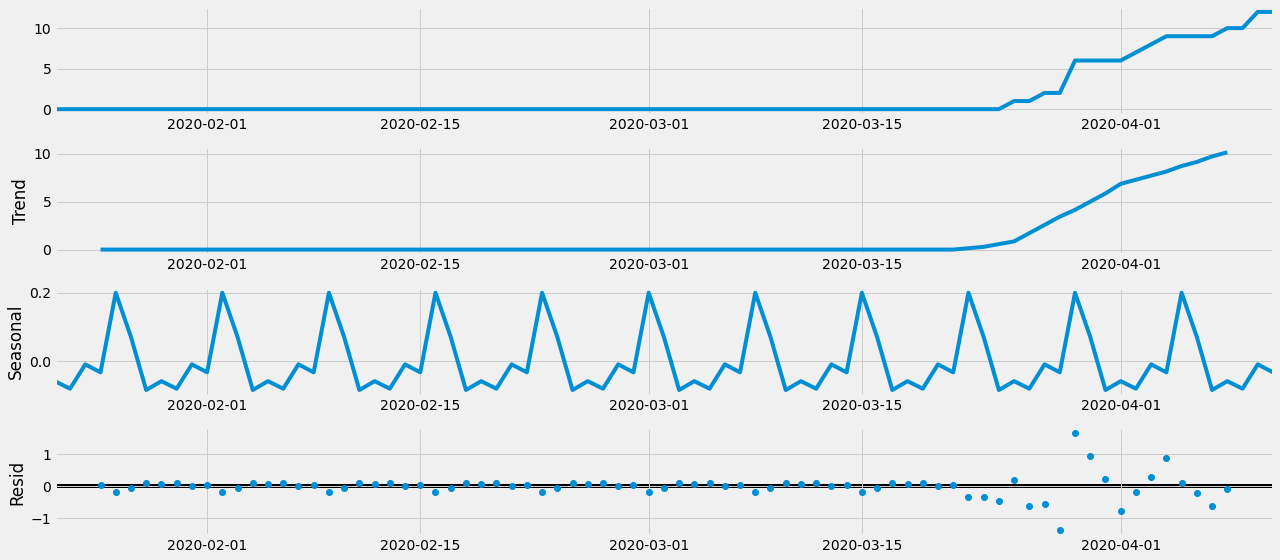

In [34]:
# Decomposition of our series
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(cam, model='additive')
fig = decomposition.plot()
plt.show()

# Modeling

In [35]:
covid.Date = pd.to_datetime(covid.Date)
covid.set_index('Date', inplace=True)

## practical functions

In [36]:
def parse_dates(dates, country):
    #print('parsing')
    ids = list()
    for date in dates:
        m = date.strftime('%m')
        d = date.strftime('%d')
        y = date.strftime('%y')

        if m.startswith('0'):
            m = m[1]
        if d.startswith('0'):
            d = d[1]

        ids.append(country + ' X ' + f'{m}/{d}/{y}')
    return ids

def save_forecasts(submission, country, forecasts):
    #print('save forecasts')
    dates = forecasts.index
    values = forecasts.values
    ids = parse_dates(dates, country)
    for id_, value in zip(ids, values):
        temp = pd.DataFrame({'Territory X Date' : [id_], 'target' : value})
        submission = submission.append(temp)
    return submission
        
def serialize(submission, nb_pred=7, algo='arima'):
    if algo == 'arima':
        file = 'arima/'
    elif algo == 'prophet':
        file = 'prophet/'
    elif algo == 'var':
        file = 'var/'
    else:
        file = 'sarimax/'
        
    if nb_pred == 7:
        file += 'SampleSubLocal' +str(int(time.time()))+ '.csv'
    else:
        file += 'SampleSubmission' +str(int(time.time()))+ '.csv'
    submission.to_csv(file, index=False)
    print('Forecasts saved in file :', file)
    
def evaluation(submission, ref):
    fusion = pd.merge(submission, ref, how='inner', on='Territory X Date')
    fusion['target_x'] = fusion['target_x'].astype(int)
    fusion['target_y'] = fusion['target_y'].astype(int)
    print('longueur fusion :',len(fusion))
    print('correlation & regression line')
    print('corr : ',fusion['target_x'].corr(fusion['target_y']))
    plt.scatter(fusion['target_x'], fusion['target_y'])
    plt.xlabel('Forecasts'), plt.ylabel('References')
    print('Mean Absolute Error : ', mean_absolute_error(fusion['target_x'], fusion['target_y']))

def correct_predictions(l):
    l = l.astype(int)
    #print(l)
    for i in range(len(l) - 1):
        if l[i+1] < l[i]:
            l[i+1] = l[i]
    return l

# Stationarity tests

# Test if mean and std are constants over the time for each country
def mean_std(countries):
    params = pd.DataFrame({'Territory': [], 'means' : [], 'stds': []})
    for country in countries:
        print(country)
        cov = covid[covid.Territory == country]
        for nb in range(10, int(len(covid) / 2), 5):
            data = cov.target.shift(-nb)
            temp = pd.DataFrame({'Territory': [country], 'means' : [data.mean()], 'stds': [data.std()]})
            params = params.append(temp, ignore_index=True)
    return params


def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {(key)}'] = value
    print (dfoutput)
    

from statsmodels.tsa.stattools import kpss
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags=None)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {(key)}'] = value
    print (kpss_output)


def stationarise(y):
    print('stationarise')
    return np.log(y+1)


def inverse_stationarise(y):
    print('inverse_stationarise')
    return np.exp(y) - 1
    

def to_stationarise(y, threshold=20):
    #params = pd.DataFrame({'means' : [], 'stds': []})
    #for nb in range(10, int(len(y) / 2), 5):
    #    data = y.target.shift(-nb)
    #    temp = pd.DataFrame({'means' : [data.mean()], 'stds': [data.std()]})
    #    params = params.append(temp, ignore_index=True)
    #if (params.means.std() > threshold) or (params.stds.std() > threshold):
    test_score = adfuller(y)[0]
    critical_value = adfuller(y)[4]['1%']
    if test_score < critical_value:
        return True
    else: 
        return False

## Building and training the models 

In [37]:
# The Models


# Test Sarimax with exogenous variables 
def SARIMAX_model(country, nb_pred=7):
    endog = covid[covid['Territory'] == country][['target']]
    exog = covid[covid['Territory'] == country][['cases', 'CFR', 'IFR', 'pop2020']]
    model = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(3,2,1), freq='D', simple_differencing=True)
    model = model.fit()
    exog_forecast = pd.DataFrame({'cases':[exog.cases.mean()]*nb_pred,
                                  'CFR':[exog.CFR.mean()]*nb_pred,
                                  'IFR':[exog.IFR.mean()]*nb_pred,
                                  'pop2020':[exog.pop2020.mean()]*nb_pred})
    forecasts = model.get_forecast(steps=nb_pred, exog=exog_forecast)
    forecasts = correct_predictions(forecasts.predicted_mean)
    index = pd.date_range(start=endog.index.max(), periods=nb_pred+1)[1:]
    forecasts = pd.DataFrame(forecasts, index=index, columns=['target'])
    return forecasts

# Building VAR (Vector AutoRegressive) model and make prediction with it
def VAR_model(country, nb_pred=7):
    data = covid[covid['Territory'] == country][['target', 'cases', 'pop2020']]
    model = VAR(endog=data, freq='D')
    model = model.fit(trend='n')
    forecasts = model.forecast(model.endog, steps=nb_pred)
    forecasts = correct_predictions(forecasts[:,0])
    index = pd.date_range(start=data.index.max(), periods=nb_pred+1)[1:]
    forecasts = pd.DataFrame(forecasts, index=index, columns=['target'])
    return forecasts

def arima_model(country, nb_pred=7):
    # just keep the rows thats refered to the current country
    y = covid[covid.Territory == country][['target']]
    
    # Arima condition : stationarity
    log_trans = False
    #if to_stationarise(y):
    #    y = stationarise(y)
    #    log_trans = True
        
    # ARIMA model
    # Select the parameters of the model
    p = d = q = range(0, 2)
    pdq = list(it.product(p, d, q))
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    BIC_list = pd.DataFrame({}, columns=['param','BIC'])
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=None)

            results = mod.fit()

            # Storage of BIC scores
            #print(f'ARIMA{param} - BIC:{results.bic}')
            temp2 = pd.DataFrame([[param, results.bic*results.aic]], columns=['param','BIC'])
            BIC_list = BIC_list.append(temp2, ignore_index=True)  # DataFrame append 
            del temp2

        except:
            continue

    
    
    l = np.nanargmin(BIC_list['BIC'].values) # Find minimum value in BIC
    Min_BIC_list = BIC_list.iloc[l,:]

    # Build the model with the best parameters
    mod = sm.tsa.statespace.SARIMAX(y,
                                    order=Min_BIC_list['param'],
                                    seasonal_order=None)
    # fit the model
    results = mod.fit()
    
    # Doing the forecasts
   
    pred = results.get_forecast(steps=nb_pred)
    forecasts = correct_predictions(pred.predicted_mean)
    if log_trans:
        forecasts = inverse_stationarise(forecasts)
    return forecasts

def prophet_model(country, nb_pred=7):
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    # just keep the rows thats refered to the current country
    covid_pro = covid[covid['Territory'] == country].reset_index()
    #covid_pro = covid.reset_index()
    
    covid_pro = covid_pro.rename(columns={'Date': 'ds', 'target': 'y'})
    model = Prophet(interval_width=0.95)
    
    model.add_regressor('cases')
    model.add_regressor('CFR')
    model.add_regressor('IFR')
    model.add_regressor('pop2020')
    model.fit(covid_pro)
    
    model_dates = model.make_future_dataframe(periods=7, freq='D')
    model_dates['cases'] = covid_pro['cases']
    model_dates['IFR'] = covid_pro['IFR']
    model_dates['CFR'] = covid_pro['CFR']
    model_dates['pop2020'] = covid_pro['pop2020']
    
    for col in model_dates.columns:
        if col == 'pop2020':
            model_dates[col] = model_dates[col].fillna(model_dates[col].min())
        else:
            model_dates[col] = model_dates[col].fillna(model_dates[col].max())

    forecasts = model.predict(model_dates)
    forecasts = forecasts[['ds','yhat']].set_index('ds')
    forecasts = forecasts.iloc[-nb_pred:]
    values = correct_predictions(forecasts.values.flatten())
    return pd.DataFrame(values, index=forecasts.index, columns=['target'])
    
    
def predictions(countries, algo='arima', nb_pred=7):
    if algo == 'arima':
        predictor = arima_model
    elif algo == 'prophet':
        predictor = prophet_model
    elif algo == 'var':
        predictor = VAR_model
    else:
        predictor = SARIMAX_model

    submission = pd.DataFrame({}, columns=['Territory X Date', 'target'])
    for country in countries:
        #print(country)
        forecasts = predictor(country, nb_pred)
        submission = save_forecasts(submission, country, forecasts)

    #print(submission.head(10))
    #print(submission.shape)
    return submission

## Forecasting 

### SARIMAX model 

In [40]:
countries = tqdm(covid.Territory.unique(), desc='countries')
submission = predictions(countries=countries, nb_pred=7, algo='sarimax')

longueur fusion : 1463
correlation & regression line
corr :  0.7295867868009356
Mean Absolute Error :  337.3656869446343


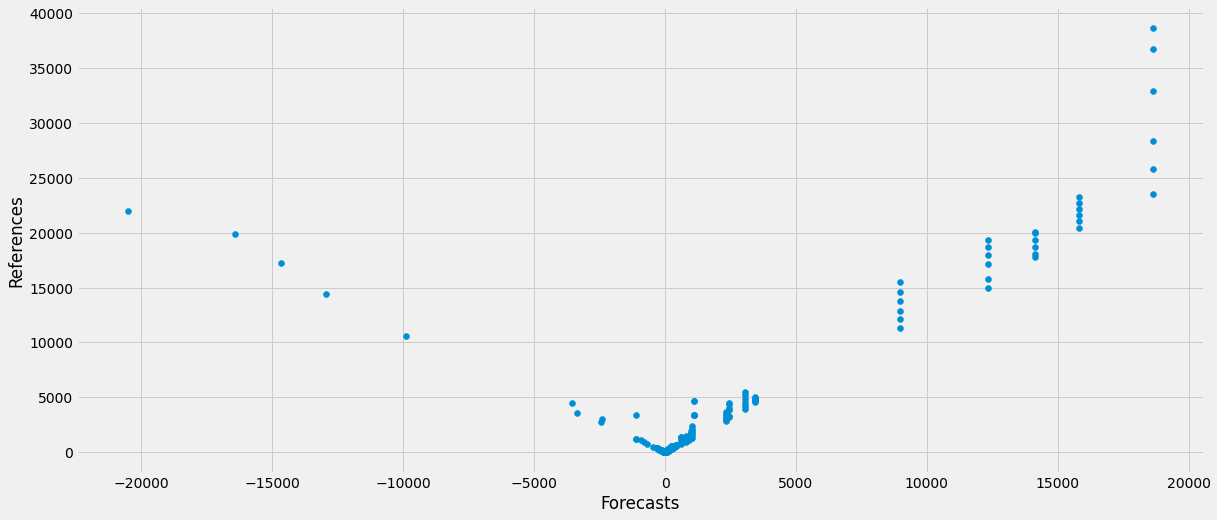

In [41]:
evaluation(submission, ref)

### Prophet model 

In [42]:
countries = tqdm(covid.Territory.unique(), desc='countries')
submission = predictions(countries=countries, nb_pred=7, algo='prophet')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

longueur fusion : 1463
correlation & regression line
corr :  0.982526917704156
Mean Absolute Error :  130.784005468216


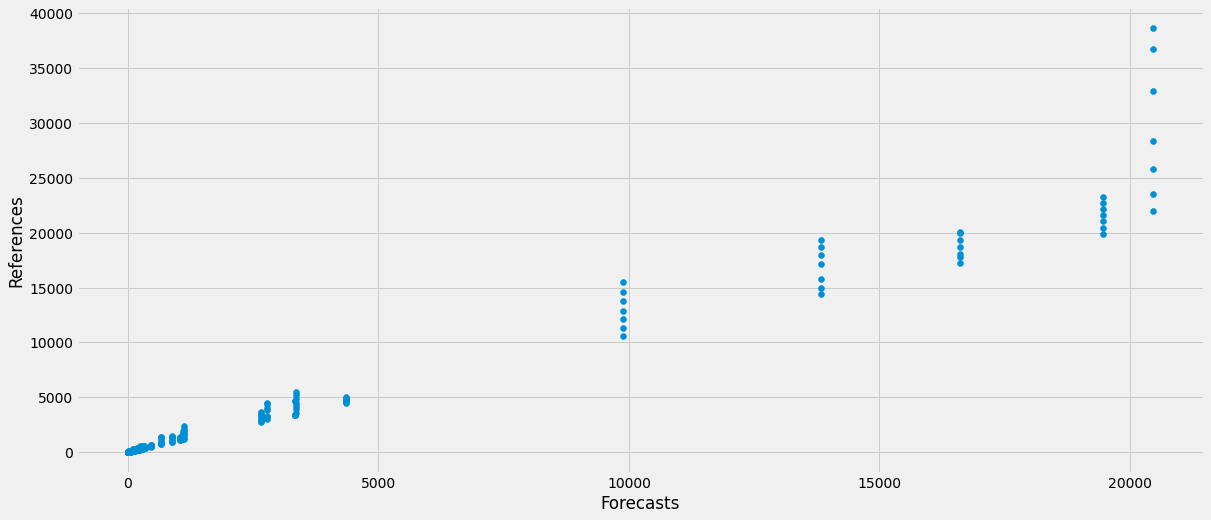

In [43]:
evaluation(submission, ref)

### VAR model 

In [40]:
countries = tqdm(covid.Territory.unique(), desc='countries')
submission = predictions(countries=countries, nb_pred=7, algo='var')

longueur fusion : 1463
correlation & regression line
corr :  0.9976881127841588
Mean Absolute Error :  40.83526999316473


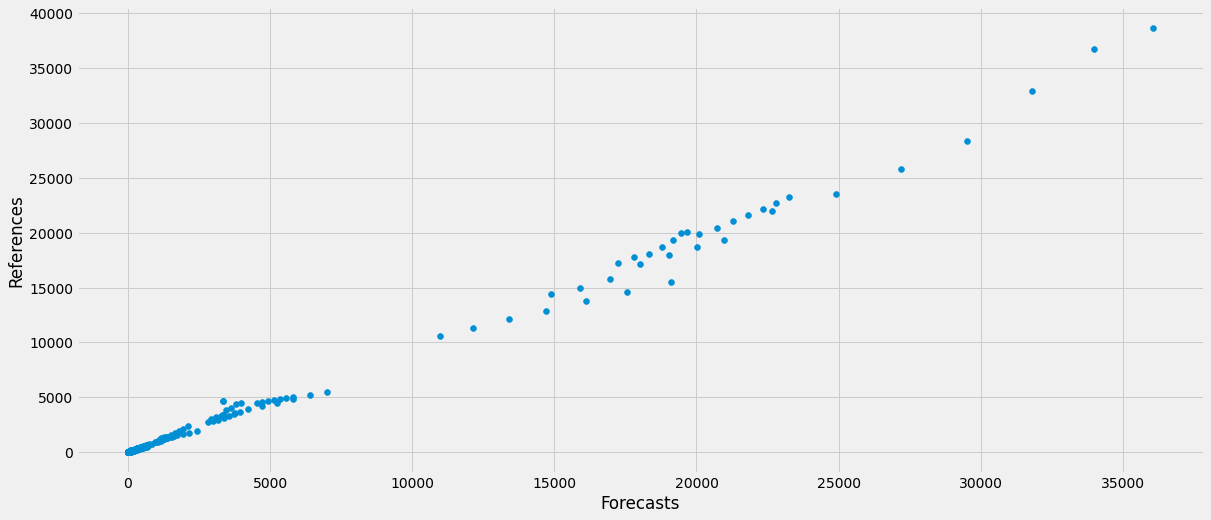

In [41]:
evaluation(submission, ref)

### ARIMA model 

In [38]:
countries = tqdm(covid.Territory.unique(), desc='countries')
submission = predictions(countries=countries, nb_pred=7, algo='arima')

longueur fusion : 1463
correlation & regression line
corr :  0.9975654196178378
Mean Absolute Error :  31.473684210526315


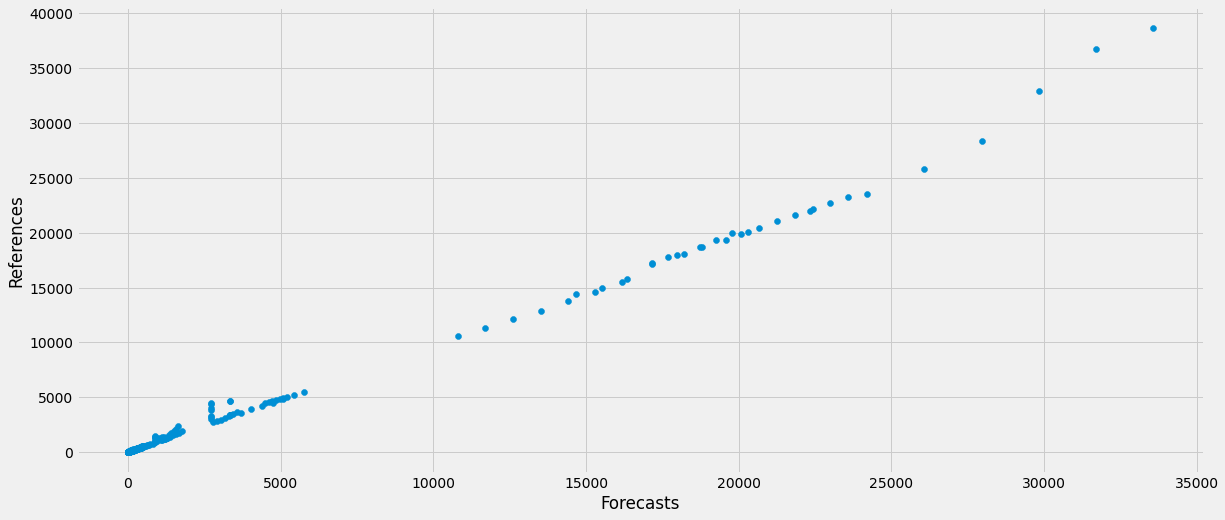

In [39]:
evaluation(submission, ref)

## Choice of the model

Summary of the models evaluation


|     ***Models***            | SARIMAX | Prophet | VAR | ARIMA|
|-----------------------------|---------|---------|-----|------|
|***Mean Absolute Error***    | 337.36  | 130.78  |40.83| 31.47|



According to the results above, we choose the ARIMA model, because it has the lowest Mean Absolute Error.

In [50]:
serialize(submission, nb_pred=7, algo='arima')

Forecasts saved in file : arima/SampleSubLocal1587826689.csv
